<a href="https://colab.research.google.com/github/astrophysicsvivien/TaylorFlow/blob/master/TF_BNS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install lalsuite pycbc

In [0]:
from pycbc.frame import read_frame
from pycbc.filter import highpass_fir, lowpass_fir
from pycbc.waveform import get_fd_waveform
from pycbc.psd import welch, interpolate
from pycbc.catalog import Merger

import pylab
import matplotlib.pyplot as plt

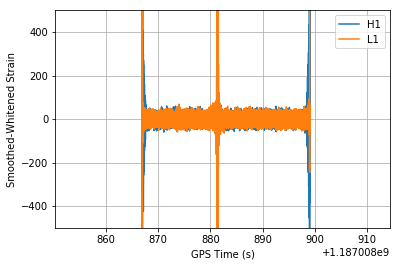

In [3]:
for ifo in ['H1', 'L1']:
    # Read data and remove low frequency content
    h1 = Merger("GW170817").strain(ifo)
    h1 = highpass_fir(h1, 15, 8)

    # Calculate the noise spectrum
    psd = interpolate(welch(h1), 1.0 / h1.duration)

    # whiten
    white_strain = (h1.to_frequencyseries() / psd ** 0.5).to_timeseries()

    # remove some of the high and low
    smooth = highpass_fir(white_strain, 35, 8)
    smooth = lowpass_fir(white_strain, 300, 8)
    
    # time shift and flip L1
    if ifo == 'L1':
        smooth *= -1
        smooth.roll(int(.007 / smooth.delta_t))
        
    pylab.plot(smooth.sample_times, smooth, label=ifo)

pylab.legend()
pylab.xlim(1187008882.4-32, 1187008882.4+32)
pylab.ylim(-500, 500)
pylab.ylabel('Smoothed-Whitened Strain')
pylab.grid()
pylab.xlabel('GPS Time (s)')
pylab.show()

/usr/local/lib/python3.6/dist-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


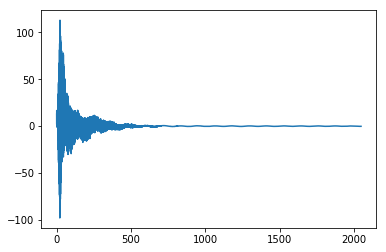

In [4]:
fd_smooth = smooth.to_frequencyseries()
plt.plot(fd_smooth.sample_frequencies,fd_smooth)

In [0]:
import tensorflow as tf
#enable Eager execution
tf.enable_eager_execution()

import numpy as np
import matplotlib.pyplot as plt
import time

In [0]:
def PN_phases(freq,mTot,eta,phase_order):
    """
    PN phase orders for TaylorF2
    """
    
    #constants in equation
    piM = tf.multiply(mTot*4.92549102554e-6,np.pi) # Total mass times pi
    v = tf.pow(tf.multiply(piM,freq),(1/3)) # characteristic velocity of binary
    etasq = tf.pow(eta,2) # square of the symmetric mass ratio
    etacb= tf.pow(eta,3) # cube of the symmetric mass ratio
    gamma = 0.577215664901532 #Euler–Mascheroni constant
    
    #v parameters
    v0 = tf.pow(v,-5)
    v2 = tf.pow(v,2)
    v3 = tf.pow(v,3)
    v4 = tf.pow(v,4)
    v5 = tf.pow(v,5)
    v5log = tf.log(v)
    v6 = tf.pow(v,6)
    v6log = tf.log(4*v)
    v7 = tf.pow(v,7)
    
    #produce PN coeffiecients
    P0 = tf.multiply((3./128),tf.reciprocal(eta))
    P2 = tf.multiply(tf.add(743/84,((11)*eta)),(5/9))
    P3 = (-16*np.pi)
    P4 = tf.multiply(tf.add((3058673/1016064),tf.add(((5429/1008)*eta),(617/144)*etasq)),(10))
    P5 = tf.multiply(tf.add(7729/84,(-13*eta)),(np.pi*5/9))
    Pl5 = tf.multiply(tf.add(7729/84,(-13*eta)),(np.pi*5/3))
    P6 = tf.add(((11583231236531/4694215680)-(640*np.pi*np.pi/3)-(6848*gamma/21)),\
         tf.add(((((-15737765635/3048192)+(2255*np.pi*np.pi/12)))*eta),\
         tf.add(((76055/1728)*etasq),(-127825/1296)*etacb)))
    Pl6 = -(6848/21)
    P7 = tf.multiply(tf.add((77096675/254016),tf.add(((378515/1512)*eta),(-74045/756)*etasq)),(np.pi))

    
    #Produce full PN terms
    PN0 = tf.multiply(P0,v0)
    PN2 = tf.multiply(P2,v2)
    PN3 = tf.multiply(P3,v3)
    PN4 = tf.multiply(P4,v4)
    PN5 = tf.multiply(tf.add(P5,tf.multiply(Pl5,v5log)),v5)
    PN6 = tf.multiply(tf.add(P6,tf.multiply(Pl6,v6log)),v6)
    PN7 = tf.multiply(P7,v7)
    
    #phases = PN_cnst + PN0(1+PN1*v+PN2*v2+PN3*v3+PN4+PN5+PN6+PN7)
    if phase_order == 7:
        phases = tf.multiply(PN0,(1+PN2+PN3+PN4+PN5+PN6+PN7))
    elif phase_order == 6:
        phases = tf.multiply(PN0,(1+PN2+PN3+PN4+PN5+PN6))
    elif phase_order == 5:
        phases = tf.multiply(PN0,(1+PN2+PN3+PN4+PN5))
    elif phase_order == 4:
        phases = tf.multiply(PN0,(1+PN2+PN3+PN4)) 
    elif phase_order == 3:
        phases = tf.multiply(PN0,(1+PN2+PN3))
    elif phase_order == 2:
        phases = tf.multiply(PN0,(1+PN2))
    elif phase_order == 1:
        phases = PN0
    else:
        phases = PN0
        

    return phases
                         
def PN_amplitude(freq,ChirpMass,LuminosityDistance):
    """
    Amplitude at 0PN order
    
    """
    #returns the amplitude of the 0PN waveform
    #arguments are chirp mass, luminosity distance and frequencies
                         
    term1 = tf.reciprocal(LuminosityDistance/299792458)# divide by factor of c to convert to units of time
    term2 = tf.multiply(np.sqrt(5/24)*(np.pi**(-2/3)),tf.pow(ChirpMass*4.92549102554e-6,(5/6))) #times by mtsol to get units of time
    term3 = tf.pow(freq,(-7/6))
                         
    return tf.multiply(term1,tf.multiply(term2,term3))
                         
def taylorf2(mass1,mass2,frequencies=None,LuminosityDistance=1.,f_low=10.,
               df=1./512,f_high=1600.,phase_order=0):
    """
    TaylorFlow Main Function
    
    """
                         
    #Define variable and constants in TensorFlow variables and constants   
    #Masses and frequencies are required inputs
    mass1 = tf.constant(mass1,name="mass1",dtype=tf.float32)
    mass2 = tf.constant(mass2,name="mass2",dtype=tf.float32)
    
    #get total mass,chirp mass and symetric mass ratio for use later in function
    M = tf.add(mass1,mass2)
    eta = tf.divide(tf.multiply(mass1,mass2),tf.pow(M,2))
    ChirpMass = tf.multiply(M,tf.pow(eta,(3/5))) #Chirp mass is given by M*(eta^3/5)   
    
    #define fISCO
    f_ISO = 1/(6.**1.5*np.pi*(M)*4.92549102554e-6) #frequency of innermost stable circular orbit (SI units)
    
    #define frequencies
    if frequencies is None:
        f = np.arange(1.,f_high,df)
        frequencies = tf.Variable(f,name= "frequencies",dtype= tf.float32)
    else: 
        frequencies[0] = 1
        frequencies = tf.Variable(frequencies,name= "frequencies",dtype= tf.float32)
        

    #other constants                     
    L_D =  tf.constant((3.086e+22*LuminosityDistance),name="LuminosityDistance",dtype=tf.float32) 
    
    #get phases at 0PN order
    phase = PN_phases(frequencies, M, eta, phase_order)
    amp = PN_amplitude(frequencies, ChirpMass, L_D)
    
    #set amplitude to zero where the waveform results are unphysical/unwanted
    cond1 = frequencies<f_low #below f_low
    ind1 = tf.where(cond1)
    cond2 = frequencies>f_ISO #above fISCO
    ind2 = tf.where(cond2)
    amp = tf.scatter_update(tf.Variable(amp), ind1, tf.constant(0.))
    amp = tf.scatter_update(tf.Variable(amp), ind2, tf.constant(0.))
    
    #Calculte waveform
    iphase = tf.multiply(tf.complex(0.,1.),tf.complex(phase-(np.pi/4)+np.pi,0.))
    waveform = tf.multiply(tf.complex(amp,0.),tf.exp(iphase))
     
    return frequencies, waveform

In [0]:
def tensornorm(a):
    """divides by max value of tensor to normalise between 0 and 1"""
    TensorMax = tf.reduce_max(tf.abs(a))
    norm_condition = tf.complex(tf.reciprocal(TensorMax),0.)
    
    return tf.multiply(a,norm_condition),norm_condition

def ComplexInnerProduct(temp,data,psd,df):
    """computes complex inner product in the fourier domain IP = 4 deltaf sum((a * conguagte(b))/Weights)"""
    
    weights = tf.sqrt(psd)
    norm = (4*df)
    a_weight = tf.div_no_nan(temp,weights)
    b_conj = tf.conj(data)
    b_weight = tf.div_no_nan(tf.cast(b_conj,dtype=tf.complex64),weights)
    a_dot_b = tf.reduce_sum(tf.multiply(a_weight,b_weight))
    
    return tf.multiply(norm,a_dot_b)

def InnerProduct(temp,data,psd,df):
    """computes inner product in the fourier domain IP = 4 deltaf RE sum((a * conguagte(b))/Weights)"""
    
    return tf.real(ComplexInnerProduct(temp,data,psd,df))

def matchedfilter(temp,data,psd,df):
    """Computes the overlap between two waveforms"""
    
    prod_a_b = InnerProduct(temp,data,psd,df)
    prod_a_a = InnerProduct(temp,temp,psd,df)
    prod_b_b = InnerProduct(data,data,psd,df)
    
    sigma = tf.sqrt(tf.multiply(prod_a_a,prod_b_b))
    
    return tf.divide(prod_a_b,sigma)

def match(temp,data,psd,df,freq,norm_condition,tc_low = -1.,tc_high = 1.):
    """Calculate the max match between two waveforms by maximisiung over coalescence time"""
    
    t_c = tf.cast(tf.linspace(tc_low,tc_high,201),dtype=tf.float32)
    freq_tc = tf.tensordot(t_c,freq,axes=0)
    freq_tc = tf.cast(freq_tc,dtype=tf.complex64)
    shift_factor = tf.exp(1j*2*np.pi*freq_tc)*norm_condition

    match_max = np.zeros(len(t_c))
    for coa_time in range(len(t_c)):
        waveform_shift = shift_factor[coa_time,:]
        waveform_shifted = tf.multiply(waveform_shift,temp)
        match_max[coa_time] = matchedfilter(waveform_shifted,data,psd,df)
    
    return t_c, match_max

def match_cpu(temp,data,psd,df,freq,norm_condition,tc_low = -1.,tc_high = 1.):
    """Calculate the max match between two waveforms by maximisiung over coalescence time, calculated on the cpu"""
    
    with tf.device('/cpu:0'):
        t_c = tf.cast(tf.linspace(tc_low,tc_high,201),dtype=tf.float32)
        freq_tc = tf.tensordot(t_c,freq1,axes=0)
        freq_tc = tf.cast(freq_tc,dtype=tf.complex64)
        shift_factor = tf.exp(1j*2*np.pi*freq_tc)*norm_condition

        match_max = np.zeros(len(t_c))
        for coa_time in range(len(t_c)):
            waveform_shift = shift_factor[coa_time,:]
            waveform_shifted = tf.multiply(waveform_shift,waveform1)
            match_max[coa_time] = matchedfilter(waveform_shifted,nwaveform1,psd1,df)
    
    return t_c, match_max

def loglikelihood(temp,data,psd,df):
    """Computes the relative log likelihood of two data sets, computed by <data|temp>-1/2<temp|temp> """
    return (InnerProduct(data,temp,psd,df)-0.5*InnerProduct(temp,temp,psd,df))


def SNR(temp,data,psd,df):
    """Compute the SNR at the true value of the parameters """

    return tf.sqrt(2*loglikelihood(temp,data,psd,df))

In [8]:
m1 = 1.46
m2 = 1.27
freq = fd_smooth.sample_frequencies
psd1 = psd
df = fd_smooth.sample_frequencies[1]-fd_smooth.sample_frequencies[0]

tf_freq,tf_waveform = taylorf2(m1,m2,frequencies=freq)

W0815 12:50:07.984766 140425043228544 deprecation.py:323] From <ipython-input-6-5deb1f575097>:119: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


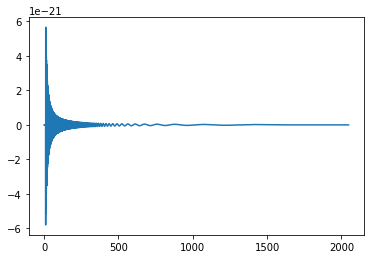

In [9]:
plt.plot(tf_freq.numpy(),tf_waveform)

In [0]:
psd1 = tf.constant(psd,dtype=tf.complex64)
match_freq = tf.cast(freq,dtype=tf.float32)

In [18]:
psd1

<tf.Tensor: id=227, shape=(65537,), dtype=complex64, numpy=
array([3.1e-44+0.j, 3.8e-44+0.j, 4.6e-44+0.j, ..., 0.0e+00+0.j,
       0.0e+00+0.j, 0.0e+00+0.j], dtype=complex64)>

In [19]:
tf_waveform

<tf.Tensor: id=167, shape=(65537,), dtype=complex64, numpy=
array([ 0.-0.j,  0.-0.j, -0.+0.j, ..., -0.+0.j, -0.+0.j, -0.+0.j],
      dtype=complex64)>

In [0]:
data = tf.constant(fd_smooth,dtype=tf.complex64)
my_temp,norm_condition = tensornorm(tf_waveform)

In [22]:
data

<tf.Tensor: id=296, shape=(65537,), dtype=complex64, numpy=
array([12.809879  +0.0000000e+00j, 11.989696  -1.1955410e-01j,
       11.41462   -2.7520773e-01j, ..., -0.18259346-5.7507681e-05j,
       -0.18057624+2.3513574e-03j, -0.17657408+0.0000000e+00j],
      dtype=complex64)>

In [30]:
print(my_temp)

tf.Tensor([ 0.+0.j  0.+0.j -0.+0.j ... -0.+0.j -0.+0.j -0.+0.j], shape=(65537,), dtype=complex64)


In [0]:
t_c, m = match(my_temp,data,psd1,df,match_freq,norm_condition)

In [33]:
CIP = ComplexInnerProduct(my_temp,data,psd1,df)
print(CIP)

tf.Tensor(0j, shape=(), dtype=complex64)


In [29]:
print(m)

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan]


In [36]:
logl= loglikelihood(my_temp,data,psd1,df)
print(logl)

tf.Tensor(0.0, shape=(), dtype=float32)
